In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from dl_biology.helper import aa_encoder
import jax
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from dl_biology.model import Rnn
from dl_biology.dataloader import PeptideDataset
from torch.utils.data import DataLoader

%load_ext autoreload
%autoreload 2


In [3]:
# import data first
filepath = "/Users/tungvuduc/Desktop/PhD/projects/repos/Deep-learning-for-biology/data/kaggle/peptide-lc-retention-time-prediction/test.csv"
test_data = pd.read_csv(filepath)

filepath = "/Users/tungvuduc/Desktop/PhD/projects/repos/Deep-learning-for-biology/data/kaggle/peptide-lc-retention-time-prediction/train.csv"
train_data = pd.read_csv(filepath)
X_train = train_data[["PeptideSequence", "Modifications"]].iloc[:8000]
y_train = train_data[["RetentionTime"]].iloc[:8000]

X_val = train_data[["PeptideSequence", "Modifications"]].iloc[8000:]
y_val = train_data[["RetentionTime"]].iloc[8000:]

In [ ]:
# lets create a vocab
amino_acids = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y"]

vocab = set(list(train_data["PeptideSequence"].sum()))
def aa_encoder(seq, vocab=None):
    """
    Encode the aa in a numerical representation
    e.g. "ACD" -> 012
    """
    if vocab is None:
        vocab = amino_acids
    amino_acid_dict = {aa: idx for idx, aa in enumerate(vocab)}
    if isinstance(seq, list):
        return [amino_acid_dict[aa] for aa in seq]

    elif isinstance(seq, str):
        return [amino_acid_dict[aa] for aa in list(seq)]

# collect all PeptideSequences and encode them
encoded_pep_seq_train = [aa_encoder(peptide, vocab) for peptide in X_train["PeptideSequence"]]
encoded_pep_seq_val = [aa_encoder(peptide, vocab) for peptide in X_val["PeptideSequence"]]

# one hot
encoded_pep_seq_train = [torch.nn.functional.one_hot(torch.tensor(enc), num_classes=len(vocab)).to(torch.float32) for enc in encoded_pep_seq_train]
encoded_pep_seq_val = [torch.nn.functional.one_hot(torch.tensor(enc), num_classes=len(vocab)).to(torch.float32) for enc in encoded_pep_seq_val]

In [20]:
# let's create the model
from torch.nn.utils.rnn import pack_padded_sequence
class Rnn(nn.Module):
    def __init__(
        self,
        vocab_size,
        hidden_size,
        num_layers,
        embedding_size=None,
    ):
        super(Rnn, self).__init__()
        if embedding_size:
            self.embedding = nn.Embedding(vocab_size, embedding_size)
        else:
            self.embedding = None

        self.rnn = nn.RNN(vocab_size, hidden_size, num_layers, batch_first=True)
        self.h2o = nn.Linear(hidden_size, 1)
        
    def forward(self, x, lengths):
        if self.embedding:
            x = self.embedding(x)
        x_packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hidden = self.rnn(x_packed)
        final_hidden = hidden[-1]
        output = self.h2o(final_hidden)
        return output

In [59]:
from torch.nn.utils.rnn import pad_sequence

# train the model
def collate_fn(batch):
    """Custom collate function for variable-length peptide sequences"""
    # Extract sequences and convert to tensors if needed
    sequences = [item["pep_seq"] for item in batch]
    rts = torch.tensor([item["rt"] for item in batch], dtype=torch.float32)
    
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    lengths = torch.tensor([len(seq) for seq in sequences])
    
    return {
        "pep_seq": sequences_padded,
        "rt": rts,
        "lengths": lengths
    }


RT mean: 43.65, std: 46.42
Epoch [1/20] Train Loss: 0.4414 | Val Loss: 0.1504
Epoch [2/20] Train Loss: 0.1549 | Val Loss: 0.1303
Epoch [3/20] Train Loss: 0.1469 | Val Loss: 0.1227
Epoch [4/20] Train Loss: 0.1386 | Val Loss: 0.1176
Epoch [5/20] Train Loss: 0.1354 | Val Loss: 0.1079
Epoch [6/20] Train Loss: 0.1260 | Val Loss: 0.1157
Epoch [7/20] Train Loss: 0.1258 | Val Loss: 0.0941
Epoch [8/20] Train Loss: 0.1161 | Val Loss: 0.1041
Epoch [9/20] Train Loss: 0.1037 | Val Loss: 0.1030
Epoch [10/20] Train Loss: 0.1021 | Val Loss: 0.0938
Epoch [11/20] Train Loss: 0.0933 | Val Loss: 0.0805
Epoch [12/20] Train Loss: 0.0987 | Val Loss: 0.0868
Epoch [13/20] Train Loss: 0.0903 | Val Loss: 0.1049
Epoch [14/20] Train Loss: 0.0880 | Val Loss: 0.1056
Epoch [15/20] Train Loss: 0.0881 | Val Loss: 0.1008
Epoch [16/20] Train Loss: 0.0865 | Val Loss: 0.0729
Epoch [17/20] Train Loss: 0.0783 | Val Loss: 0.0812
Epoch [18/20] Train Loss: 0.0765 | Val Loss: 0.0755
Epoch [19/20] Train Loss: 0.0669 | Val Loss: 0

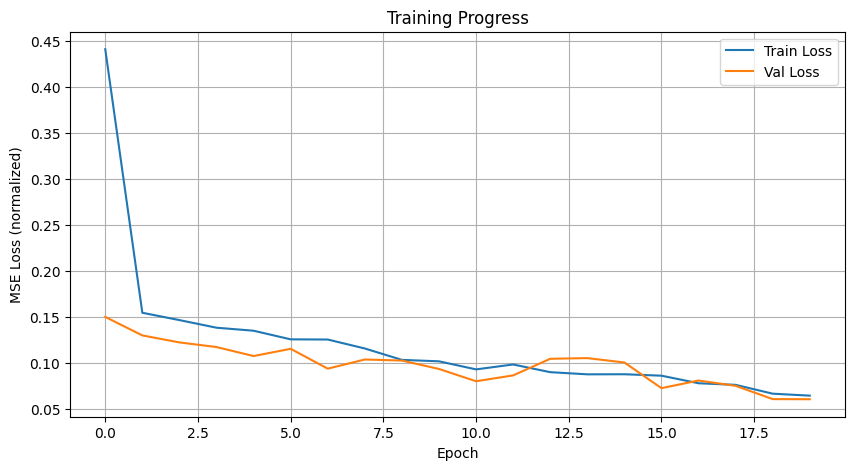


Sample predictions (denormalized):
True: 38.30 | Pred: 42.23
True: -8.85 | Pred: -11.22
True: 132.05 | Pred: 134.71
True: -18.06 | Pred: -6.15
True: 67.93 | Pred: 73.91


In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence
from torch.utils.data import DataLoader
import numpy as np

# ============= 1. NORMALIZE YOUR TARGETS =============
# This is CRITICAL for training stability
rt_mean = y_train.values.mean()
rt_std = y_train.values.std()

print(f"RT mean: {rt_mean:.2f}, std: {rt_std:.2f}")

y_train_normalized = (y_train.values.flatten() - rt_mean) / rt_std
y_val_normalized = (y_val.values.flatten() - rt_mean) / rt_std

# ============= 2. FIX MODEL OUTPUT =============
class Rnn(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers, embedding_size=None):
        super(Rnn, self).__init__()
        
        if embedding_size:
            self.embedding = nn.Embedding(vocab_size, embedding_size)
            rnn_input_size = embedding_size
        else:
            self.embedding = None
            rnn_input_size = vocab_size
        
        self.rnn = nn.RNN(rnn_input_size, hidden_size, num_layers, batch_first=True)
        self.h2o = nn.Linear(hidden_size, 1)
    
    def forward(self, x, lengths):
        if self.embedding is not None:
            x = self.embedding(x)
        
        x_packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hidden = self.rnn(x_packed)
        final_hidden = hidden[-1]
        output = self.h2o(final_hidden)
        
        return output.squeeze(-1)  #(batch, 1) -> (batch,)

# ============= 3. CREATE DATASETS WITH NORMALIZED DATA =============
train_dataset = PeptideDataset(encoded_pep_seq_train, y_train_normalized)
val_dataset = PeptideDataset(encoded_pep_seq_val, y_val_normalized)

dataloader_train = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
dataloader_val = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# ============= 4. INITIALIZE MODEL =============
vocab_size = len(vocab)
hidden_size = 64
num_layers = 2
rnn_model = Rnn(vocab_size=vocab_size, hidden_size=hidden_size, num_layers=num_layers)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001)

# ============= 5. PROPER TRAINING LOOP =============
num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # ===== TRAINING =====
    rnn_model.train()
    train_loss = 0
    
    for batch in dataloader_train:
        seq = batch["pep_seq"]
        rt = batch["rt"]
        lengths = batch["lengths"]
        
        # Forward pass
        output = rnn_model(seq, lengths)
        loss = criterion(output, rt)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping (prevents exploding gradients)
        torch.nn.utils.clip_grad_norm_(rnn_model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(dataloader_train)
    train_losses.append(avg_train_loss)
    
    # ===== VALIDATION =====
    rnn_model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for batch in dataloader_val:
            seq = batch["pep_seq"]
            rt = batch["rt"]
            lengths = batch["lengths"]
            
            output = rnn_model(seq, lengths)
            loss = criterion(output, rt)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(dataloader_val)
    val_losses.append(avg_val_loss)
    
    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

# ============= 6. PLOT LEARNING CURVES =============
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (normalized)')
plt.legend()
plt.title('Training Progress')
plt.grid(True)
plt.show()

# ============= 7. TEST PREDICTIONS =============
rnn_model.eval()
with torch.no_grad():
    test_batch = next(iter(dataloader_val))
    seq = test_batch["pep_seq"]
    rt_true = test_batch["rt"]
    lengths = test_batch["lengths"]
    
    rt_pred = rnn_model(seq, lengths)
    
    # Denormalize for comparison
    rt_true_denorm = rt_true * rt_std + rt_mean
    rt_pred_denorm = rt_pred * rt_std + rt_mean
    
    print("\nSample predictions (denormalized):")
    for i in range(min(5, len(rt_true))):
        print(f"True: {rt_true_denorm[i].item():.2f} | Pred: {rt_pred_denorm[i].item():.2f}")


In [37]:
# perform the validation prediction for all val RTs
rnn_model.eval()
rt_preds = []
with torch.no_grad():
    for batch in dataloader_val:

        seq = batch["pep_seq"]
        rt_true = batch["rt"]
        lengths = batch["lengths"]
    
        rt_pred = rnn_model(seq, lengths)
    
        # Denormalize for comparison
        rt_pred_denorm = rt_pred * rt_std + rt_mean
        rt_preds.append(rt_pred_denorm)

Pearon corr:  0.9697243197603233
MAE 7.509501160686917


/var/folders/8z/k5tph_7d3cd3tq2s362kbfch0000gn/T/ipykernel_89085/192711063.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  rt_preds = np.array(torch.cat(rt_preds))


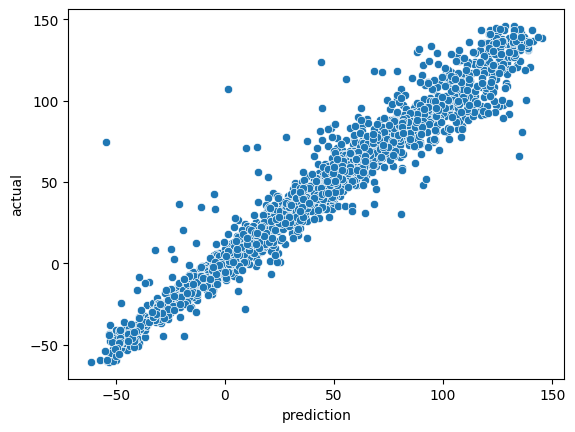

In [48]:
rt_preds = np.array(torch.cat(rt_preds))
y_pred = rt_preds
y_true = y_val.values.flatten()
sns.scatterplot(
    x=y_pred,
    y=y_true
)
plt.xlabel("prediction")
plt.ylabel("actual")
print("Pearon corr: ", np.corrcoef(y_pred, y_true)[0, -1])
def mae(y_pred, y):
    return np.mean(np.abs(y_pred -y))
print(f"MAE {mae(y_pred, y_true)}")